In [ ]:
!pip install scipy cartopy h5py matplotlib numpy netCDF4 sklearn mpl-scatter-density

     |████████████████████████████████| 12.1 MB 131 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 655 kB 47.7 MB/s 
     |████████████████████████████████| 219 kB 58.4 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516278 sha256=360afb5a1b34a7938cb46ccf63a6d016dcdaf8fb729107d5b4acc1a6910539c5
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37325 sha256=bca231aaeefe0eabacf014e7c5488f8f7b6cd8037a35cb3bf0d4821cdf0f4425
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built cartopy pyshp


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
import scipy
import math
import matplotlib
#matplotlib.use('agg')
import cartopy.crs as ccrs
from netCDF4 import Dataset
import h5py
import numpy as np
from pylab import *
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

#Simply forces python to avoid printing output in scientific notation 
np.set_printoptions(suppress=True)

#Mounts your goodle drive, allowing you to read in files from google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Reading Radiances from OMI L1b file 
filename = 'drive/MyDrive/PCA_Sample/OMI-Aura_L1-OML1BRVG_2005m0131t0352-o002911_v0400-2021m0804t2310.nc'

f = Dataset(filename,'r')
radiance = f['/BAND3_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]
radiance_wavelengths = f['/BAND3_RADIANCE/STANDARD_MODE/INSTRUMENT/wavelength'][0,:,:]
longitude = f['/BAND3_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
latitude = f['/BAND3_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
sza = f['/BAND3_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]
latitude[sza > 80] = np.nan
#NetCDF4 makes masked arrays where values are NaN, here we swap out the mask for NaN
radiance = np.ma.filled(radiance,float('nan'))
radiance_wavelengths = np.ma.filled(radiance_wavelengths,float('nan'))  

In [ ]:
#Reading irradiances 
filename = 'drive/MyDrive/PCA_Sample/OMI-Aura_L1-OML1BIRR_2005m0321t0937-o003628_v0400-2021m0513t1538.nc'
f = Dataset(filename,'r')
irradiance = f['/BAND3_IRRADIANCE/STANDARD_MODE/OBSERVATIONS/irradiance'][0,0,:,:]
irradiance_wavelengths = f['/BAND3_IRRADIANCE/STANDARD_MODE/INSTRUMENT/wavelength'][0,:,:]

#NetCDF4 makes masked arrays where values are NaN, here we swap out the mask for NaN
irradiance = np.ma.filled(irradiance,float('nan'))
irradiance_wavelengths = np.ma.filled(irradiance_wavelengths,float('nan'))

In [ ]:
#Creating a new array to store irradiances that are interpolated to radiance wavelengths 
#Zeros_like simply makes an array filled with 0's that has the same size as the provided array 
irradiance_interpolated = np.zeros_like(irradiance) + np.nan

#Looping through the rows and interpolating the irradiances to the radiance wavelengths 
for row in range(60):
    linear_interp = interp1d(irradiance_wavelengths[row,:],irradiance[row,:],kind='linear',bounds_error=False,fill_value=np.nan)
    irradiance_interpolated[row,:] = linear_interp(radiance_wavelengths[row,:])


In [ ]:
sun_norm_radiances = radiance/irradiance_interpolated
line,row,n_wavel = sun_norm_radiances.shape
sun_norm_radiances = sun_norm_radiances.reshape(line*row,n_wavel)
print(sun_norm_radiances.shape)

#Normalize the sun_norm_radiances
#mean_dev = sun_norm_radiances-np.nanmean(sun_norm_radiances)
#std_dev = np.nanstd(sun_norm_radiances)
#sun_norm_radiances = mean_dev/std_dev
#Scaling spectra by scalar coefficient
#sun_norm_radiances = 5.0*sun_norm_radiances

(98640, 751)


In [ ]:
#wave_ind1=33 corresponds to approximately 350nm, wave_ind2=750 corresponds to approximately 500nm
#These indexes are based on row-0 from "radiance_wavelengths", so to change them, use radiance_wavelengths
#to determine the indexes for the wavelength range you want to look at 
wave_ind1 = 33
wave_ind2 = 750

#Perform PCA decomposition. Here reflectance is refl(n_sample,n_lambda)
covmatrix = np.dot(sun_norm_radiances[:,wave_ind1:wave_ind2].T ,sun_norm_radiances[:,wave_ind1:wave_ind2])
_, pca_coeff = np.linalg.eigh(covmatrix)
pca_coeff = pca_coeff[:,::-1]
pca_coeff_orig = np.array(pca_coeff)
print(pca_coeff.shape)

eigenvector0 = pca_coeff[:, 0]
eigenvector101 = pca_coeff[:, 101]
scatter(pca_coeff[:,0],pca_coeff[:,1])
scatter(pca_coeff[:,1],pca_coeff[:,2])
#scatter(pca_coeff[:,2],pca_coeff[:,3])
#scatter(pca_coeff[:,3],pca_coeff[:,4])
#scatter(pca_coeff[:,440],pca_coeff[440,:])

pca_proj = np.swapaxes(np.dot(pca_coeff.T,sun_norm_radiances[:,wave_ind1:wave_ind2].T),0,1)

(717, 717)


In [ ]:
fig, axes = plt.subplots(figsize=(12,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

axes.set_xticks(np.arange(-180,200,30))
axes.set_yticks(np.arange(-90,110,20))
axes.grid()
axes.coastlines(resolution='50m')

#Suggest changing the pca number to see what features appear for other PC's
pca_num = 1

mns = np.nanmean(pca_proj[:,pca_num])
std = np.nanstd(pca_proj[:,pca_num])
im = axes.scatter(longitude.flatten(),latitude.flatten(),c=pca_proj[:,pca_num],lw=0,s=1,cmap=plt.cm.jet,vmin=mns-std,vmax=mns+std)
#fig.colorbar(im)
plt.suptitle('Coefficient of PCA '+str(pca_num),fontsize=30)
plt.show()
#plt.savefig('Coeff_of_PCA'+pca_num+.png')
plt.clf()
plt.close()

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


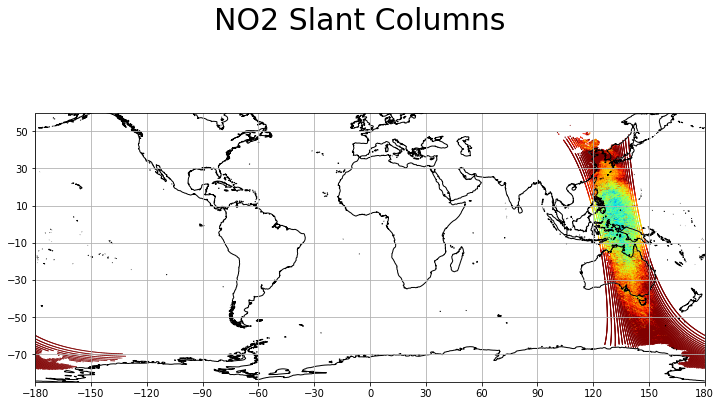

In [ ]:
#Reading and mapping NO2 slant columns from OMI Col 4 NO2 file 
f = h5py.File('drive/MyDrive/PCA_Sample/OMI-Aura_L2-OMNO2_2005m0131t0352-o02911_v003-2019m0814t183043.he5','r')
no2_scd = f['/HDFEOS/SWATHS/ColumnAmountNO2/Data Fields/SlantColumnAmountNO2'][:]
no2_scd[no2_scd == -2**100] = np.nan

#Reading in the cloud fraction data. It is stored at integers scaled by 1000 so converting to floats 
#and removing the scaling by dividing by 1000
cloud_fraction = f['/HDFEOS/SWATHS/ColumnAmountNO2/Data Fields/CloudFraction'][:]
cloud_fraction = np.array(cloud_fraction,dtype=np.float)
cloud_fraction[(cloud_fraction < 0) | (cloud_fraction == -32767)] = np.nan
cloud_fraction = cloud_fraction /1000.

#Using GroundPixelQualityFlags to set any cloud fractions with snow on the ground to NaN as 
#error is high for cloud fraction over snow covered pixel 
gpqf = f['/HDFEOS/SWATHS/ColumnAmountNO2/Geolocation Fields/GroundPixelQualityFlags'][:]
x, y = gpqf.shape
gpqf = np.array([i >> 8 for i in gpqf.flatten()]).reshape(x,y)
cloud_fraction[(gpqf != 0) & (gpqf != 104)] = np.nan 

no2_scd[(gpqf != 0) & (gpqf != 104)] = np.nan

fig, axes = plt.subplots(figsize=(12,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

axes.set_xticks(np.arange(-180,200,30))
axes.set_yticks(np.arange(-90,110,20))
axes.grid()
axes.coastlines(resolution='50m')

im = axes.scatter(longitude.flatten(),latitude.flatten(),c=no2_scd/(10e16),lw=0,s=1,cmap=plt.cm.jet,vmin=0,vmax=0.1)

#fig.colorbar(im)
plt.suptitle('NO2 Slant Columns',fontsize=30)
plt.show()
#plt.savefig('Coeff_of_PCA1.png')
plt.clf()
plt.close()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#Inputs and outputs to machine learning models should be scaled to account for the fact that some data could be sparsely distributed 
sc_in = StandardScaler()
pca_proj_scaled = sc_in.fit_transform(pca_proj)

sc_out = StandardScaler()
no2_scd_scaled = sc_out.fit_transform(no2_scd.reshape(-1,1))

#Defining an input layer to the neural network
inputs = tf.keras.Input(shape=(len(pca_proj[0,:])))

#Splitting data for Row by Row training?
#inds = ~np.isnan(no2_scd.flatten())

#pca_proj_scaled_train = pca_proj_scaled[1,:]
#pca_proj_scaled_test = pca_proj_scaled[1,:]
#no2_scd_scaled_train = no2_scd_scaled[1,:]
#no2_scd_scaled_test = no2_scd_scaled[1,:]

#Splitting the data in half, 50% for training the model, 50% for testing. Note data with NaN is ignored as it causes the model to fail 
inds = ~np.isnan(no2_scd.flatten())
pca_proj_scaled_train,pca_proj_scaled_test,no2_scd_scaled_train,no2_scd_scaled_test = train_test_split(pca_proj_scaled[inds,:],no2_scd_scaled.flatten()[inds],test_size=0.5)


#Defining simply 3 layer neural network with relu activation layer for first 2 layers, linear for last layer (linear in last layer because some outputs < 0 when scaled)
layer1 = tf.keras.layers.Dense(64, activation='relu')(inputs)
layer2 = tf.keras.layers.Dense(64, activation='relu')(layer1)
out = tf.keras.layers.Dense(1,activation='linear')(layer2)

#Training the neural network using mean squared error loss function
#Epochs are the number of iterations the nueral network is run, batch size is the number of inputs trained per iteration (higher batch means quicker training)
model = tf.keras.Model(inputs, out, name="NO2Model")
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt, metrics=['mae','mse','acc','mape'])
model.fit(pca_proj_scaled_train, no2_scd_scaled_train, epochs=50, batch_size=32)

#!mkdir -p saved_model
model.save('2005m0131_East Asia_v2.h5')

Epoch 1/50
824/824 [==============================] - 3s 2ms/step - loss: 0.4623 - mae: 0.3912 - mse: 0.4623 - acc: 0.0000e+00 - mape: 441.7217
Epoch 2/50
824/824 [==============================] - 2s 2ms/step - loss: 0.2768 - mae: 0.2633 - mse: 0.2768 - acc: 0.0000e+00 - mape: 300.2580
Epoch 3/50
824/824 [==============================] - 2s 2ms/step - loss: 0.1889 - mae: 0.2558 - mse: 0.1889 - acc: 0.0000e+00 - mape: 272.2085
Epoch 4/50
824/824 [==============================] - 2s 2ms/step - loss: 0.4466 - mae: 0.2848 - mse: 0.4466 - acc: 0.0000e+00 - mape: 355.9173
Epoch 5/50
824/824 [==============================] - 2s 2ms/step - loss: 0.6179 - mae: 0.2750 - mse: 0.6179 - acc: 0.0000e+00 - mape: 342.2880
Epoch 6/50
824/824 [==============================] - 2s 2ms/step - loss: 3.7428 - mae: 0.3739 - mse: 3.7428 - acc: 0.0000e+00 - mape: 526.6109
Epoch 7/50
824/824 [==============================] - 2s 2ms/step - loss: 3.2960 - mae: 0.3464 - mse: 3.2960 - acc: 0.0000e+00 - mape: 5

In [ ]:
fig, axes = plt.subplots(figsize=(10,10))

#Predicting no2_scd for 50% of data left aside for testing and then inverting the scaling 
no2_scd_predict = sc_out.inverse_transform(model.predict(pca_proj_scaled_test))
no2_scd_test_unscaled = sc_out.inverse_transform(no2_scd_scaled_test.reshape(-1,1))
r2 = r2_score(no2_scd_test_unscaled, no2_scd_predict)
rmse = sqrt(mean_squared_error(no2_scd_test_unscaled, no2_scd_predict))
print(r2)
print(rmse)

#Making simple scatter plot to compare predictions of no2_scd with the truth 
axes.scatter(no2_scd_predict,no2_scd_test_unscaled)
axes.set_xlabel('Predicted NO2 Slant Column Density',fontsize=20)
axes.set_ylabel('Actual NO2 Slant Column Density',fontsize=20)
axes.plot([0,10e16],[0,10e16],'--',color='k',lw=5)
axes.set_aspect(1)
axes.set_xlim(0,10e16)
axes.set_ylim(0,10e16)
title('Without Normalization before PCA',fontsize=20)

axes.tick_params(labelsize=16)

0.8786708944552301
2597850200000000.0


/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


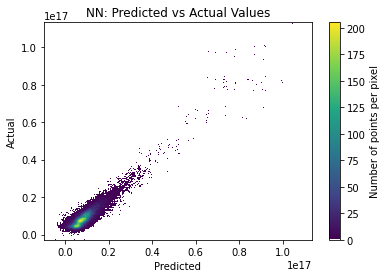

In [ ]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig,no2_scd_predict,no2_scd_test_unscaled):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(no2_scd_predict,no2_scd_test_unscaled,cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure()
using_mpl_scatter_density(fig, no2_scd_predict,no2_scd_test_unscaled)
xlabel('Predicted')
ylabel('Actual')
title('NN: Predicted vs Actual Values')
plt.show()

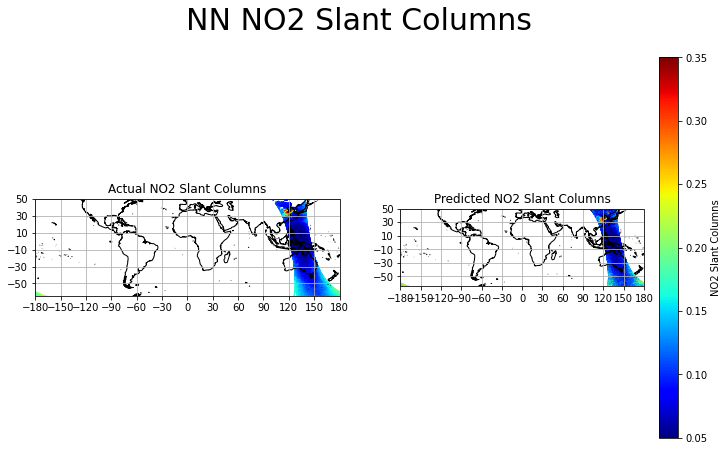

In [ ]:
#Make NO2 prediction for train and test data then you can map all the data
no2_scd_predict = sc_out.inverse_transform(model.predict(pca_proj_scaled))

fig, axes = plt.subplots(1,2,figsize=(12,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

for ax in axes.flatten():
  ax.set_xticks(np.arange(-180,200,30))
  ax.set_yticks(np.arange(-90,110,20))
  ax.grid()
  ax.coastlines(resolution='50m')
  #ax.set_xlim([-80,-20])
  ax.set_ylim([-65,50])

im = axes[1].scatter(longitude.flatten(),latitude.flatten(),c=no2_scd_predict/(10e16),lw=0,s=1,cmap=plt.cm.jet,vmin=0.05,vmax=0.35)
im = axes[0].scatter(longitude.flatten(),latitude.flatten(),c=no2_scd/(10e16),lw=0,s=1,cmap=plt.cm.jet,vmin=0.05,vmax=0.35)
axes[0].set_title('Actual NO2 Slant Columns')
axes[1].set_title('Predicted NO2 Slant Columns')
plt.suptitle('NN NO2 Slant Columns',fontsize=30)
cb = fig.colorbar(im)
cb.set_label('NO2 Slant Columns')
plt.show()
plt.clf()
plt.close()

3.1871282e+16
-5.2482604e+17
203498.61


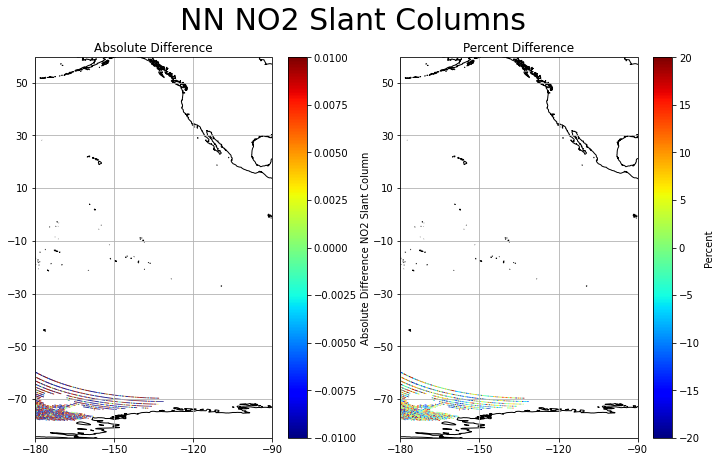

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,7),subplot_kw=dict(projection=ccrs.PlateCarree()))

abs_diff = no2_scd-no2_scd_predict.reshape(-1,60)
percent_diff = (abs_diff/no2_scd)*100
#with np.printoptions(threshold=np.inf):
 # print(difference)
print(np.nanmax(abs_diff))
print(np.nanmin(abs_diff))
print(np.nanmax(percent_diff))
 
for ax in axes.flatten():
  ax.set_xticks(np.arange(-180,200,30))
  ax.set_yticks(np.arange(-90,110,20))
  ax.grid() 
  ax.coastlines(resolution='50m')
  ax.set_xlim([-180,-90])
  #ax.set_ylim([-60,60])

ax1 = axes[0]
im1 = axes[0].scatter(longitude.flatten(),latitude.flatten(),c=abs_diff/(10e16),lw=0,s=1,cmap=plt.cm.jet,vmin=-0.01,vmax=0.01)
axes[1].set_title('Percent Difference')
cb1 = fig.colorbar(im1,ax=ax1)
cb1.set_label('Absolute Difference NO2 Slant Column')
ax2 = axes[1]
im2 = axes[1].scatter(longitude.flatten(),latitude.flatten(),c=percent_diff,lw=0,s=1,cmap=plt.cm.jet,vmin=-20,vmax=20)
axes[0].set_title('Absolute Difference')
plt.suptitle('NN NO2 Slant Columns',fontsize=30)
cb2 = fig.colorbar(im2,ax=ax2)
cb2.set_label('Percent') 
plt.show()
plt.clf()
plt.close()